# IVP Final Project 

### Implementing Optical Flow Estimation by Iterative Algorithms 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


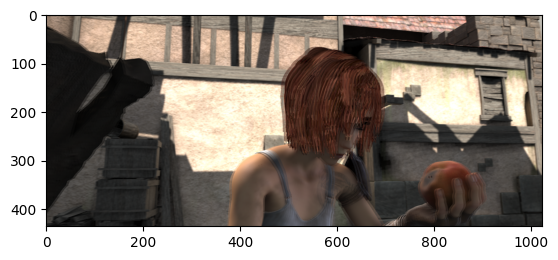

In [ ]:
import glob
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive/')




img1 = cv2.imread("/content/drive/My Drive/IVP_Project/frame_0001.png")
img2 = cv2.imread("/content/drive/My Drive/IVP_Project/frame_0002.png")

i = 1
alpha = 1.0/(i + 1)
beta = 1.0 - alpha

avg_image = cv2.addWeighted(img1, alpha, img2, beta, 0.0)

cv2.imwrite('avg_happy_face.png', avg_image)
avg_image = cv2.imread('avg_happy_face.png')
avg_image = cv2.cvtColor(avg_image, cv2.COLOR_BGR2RGB)
plt.imshow(avg_image)
plt.show()

## Plotting the Average of the two frames 

# Dense Optical Flow Using Farneback Algorithm 


In [ ]:
def compute_dense_optical_flow(prev_image, current_image):
  old_shape = current_image.shape
  prev_image_gray = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
  current_image_gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
  assert current_image.shape == old_shape
  hsv = np.zeros_like(prev_image)
  hsv[..., 1] = 255
  flow = None
  flow = cv2.calcOpticalFlowFarneback(prev=prev_image_gray,
                                      next=current_image_gray, flow=flow,
                                      pyr_scale=0.8, levels=15, winsize=5,
                                      iterations=10, poly_n=5, poly_sigma=0,
                                      flags=10)

  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  hsv[..., 0] = ang * 180 / np.pi / 2
  hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
  return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR) 

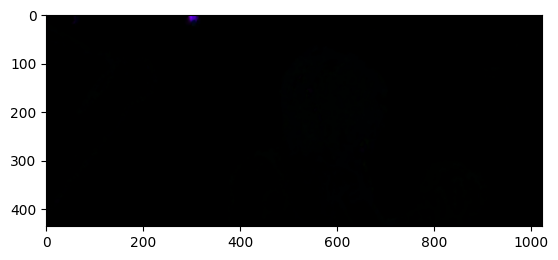

In [ ]:
flow = compute_dense_optical_flow(img1,img2)

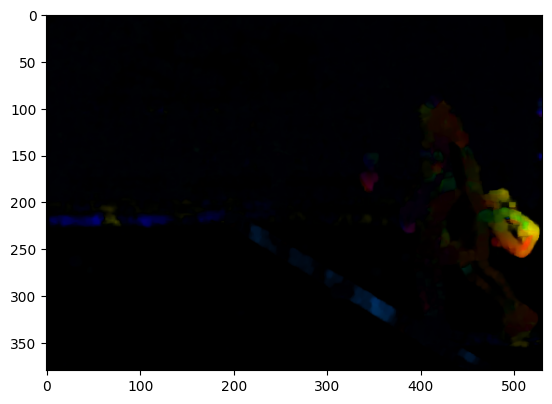

In [ ]:
## Applying the Farneback algorithm for different set of images 

img1_tennis = cv2.imread("/content/drive/My Drive/IVP_Project/tennis454.jpg")
img2_tennis = cv2.imread("/content/drive/My Drive/IVP_Project/tennis455.jpg")

flow_tennis = compute_dense_optical_flow(img1_tennis,img2_tennis)
plt.imshow(flow_tennis)
plt.show()



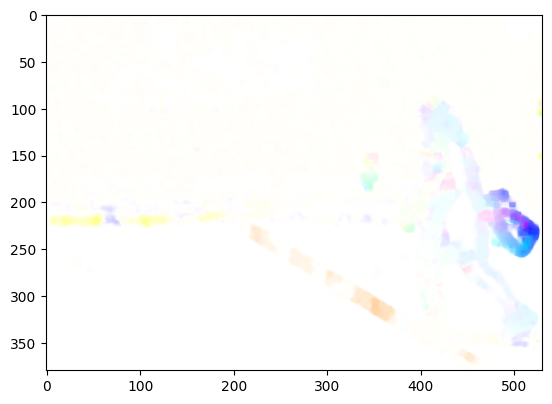

In [ ]:
inverted_image = np.invert(flow_tennis)
plt.imshow(inverted_image)
plt.show()

TV- L1 regularization Optical Flow 


In [ ]:
frame0 = cv2.imread('/content/drive/My Drive/IVP_Project/1.png', cv2.IMREAD_GRAYSCALE);
frame1 = cv2.imread('/content/drive/My Drive/IVP_Project/2.png', cv2.IMREAD_GRAYSCALE);

In [ ]:
import time
st = time.time()

optical_flow = cv2.optflow.DualTVL1OpticalFlow_create()
flowDTVL1=optical_flow.calc(frame0,frame1,None)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 58.28648400306702 seconds


In [ ]:
def ToImg(raw_flow,bound):
    '''
    this function scale the input pixels to 0-255 with bi-bound
    :param raw_flow: input raw pixel value (not in 0-255)
    :param bound: upper and lower bound (-bound, bound)
    :return: pixel value scale from 0 to 255
    '''
    flow=raw_flow
    flow[flow>bound]=bound
    flow[flow<-bound]=-bound
    flow-=-bound
    flow*=(255/float(2*bound))
    return flow
    
def save_flows(flows,image,bound):
    '''
    To save the optical flow images and raw images
    :param flows: contains flow_x and flow_y
    :param image: raw image
    :param save_dir: save_dir name (always equal to the video id)
    :param num: the save id, which belongs one of the extracted frames
    :param bound: set the bi-bound to flow images
    :return: return 0
    '''
    #rescale to 0~255 with the bound setting
    flow_x=ToImg(flows[...,0],bound)
    flow_y=ToImg(flows[...,1],bound)

    #save the image
    
    cv2.imwrite('save_image.jpg', image)
    avg_image = cv2.imread('save_image.jpg')
    plt.imshow(avg_image)
    plt.show()  

    #save the flows
    
    flow_x_img=Image.fromarray(flow_x)
    flow_y_img=Image.fromarray(flow_y)
    cv2.imwrite('flow_x_img.jpg',flow_x_img)
    avg_image = cv2.imread('flow_x_img.jpg')
    plt.imshow(avg_image)
    plt.show()
    cv2.imwrite('flow_y_img.jpg',flow_y_img)
    avg_image = cv2.imread('flow_y_img.jpg')
    plt.imshow(avg_image)
    plt.show()
    return 0

In [ ]:
def compute_color(u,v):
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img

def make_color_wheel():
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

def flow_to_image(flow):
    """
    :param flow:
    :return:
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    maxrad = -1

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    print("max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))
    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


max flow: -1.0000 flow range: u = 0.000 .. 195.945; v = 32.863 .. 255.000


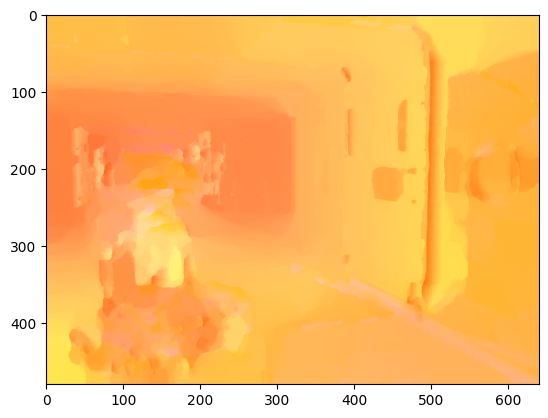

In [ ]:
UNKNOWN_FLOW_THRESH = 1e7
tv_image = flow_to_image(flowDTVL1)
plt.imshow(tv_image)
plt.show()

In [ ]:
#!/usr/bin/python
import numpy as np
import matplotlib.pyplot as plt
UNKNOWN_FLOW_THRESH = 1e7


def evaluate_flow_file(gt, pred):
    """
    evaluate the estimated optical flow end point error according to ground truth provided
    :param gt: ground truth file path
    :param pred: estimated optical flow file path
    :return: end point error, float32
    """
    # Read flow files and calculate the errors
    gt_flow = read_flow(gt)        # ground truth flow
    eva_flow = read_flow(pred)     # predicted flow
    # Calculate errors
    average_pe = flow_error(gt_flow[:, :, 0], gt_flow[:, :, 1], eva_flow[:, :, 0], eva_flow[:, :, 1])
    return average_pe


def evaluate_flow(gt_flow, pred_flow):
    """
    gt: ground-truth flow
    pred: estimated flow
    """
    average_pe = flow_error(gt_flow[:, :, 0], gt_flow[:, :, 1], pred_flow[:, :, 0], pred_flow[:, :, 1])
    return average_pe


# show flow file visualization
def show_flow(filename):
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()


# WARNING: this will work on little-endian architectures (eg Intel x86) only!
def read_flow(filename):
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print('Magic number incorrect. Invalid .flo file')
    else:
        w = np.fromfile(f, np.int32, count=1)
        h = np.fromfile(f, np.int32, count=1)
        print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d


# Calculate average end point error
def flow_error(tu, tv, u, v):
    smallflow = 0.0
    '''
    stu = tu[bord+1:end-bord,bord+1:end-bord]
    stv = tv[bord+1:end-bord,bord+1:end-bord]
    su = u[bord+1:end-bord,bord+1:end-bord]
    sv = v[bord+1:end-bord,bord+1:end-bord]
    '''
    stu = tu[:]
    stv = tv[:]
    su = u[:]
    sv = v[:]

    idxUnknow = (abs(stu) > UNKNOWN_FLOW_THRESH) | (abs(stv) > UNKNOWN_FLOW_THRESH)
    stu[idxUnknow] = 0
    stv[idxUnknow] = 0
    su[idxUnknow] = 0
    sv[idxUnknow] = 0

    ind2 = [(np.absolute(stu) > smallflow) | (np.absolute(stv) > smallflow)]
    index_su = su[ind2]
    index_sv = sv[ind2]
    an = 1.0 / np.sqrt(index_su ** 2 + index_sv ** 2 + 1)
    un = index_su * an
    vn = index_sv * an

    index_stu = stu[ind2]
    index_stv = stv[ind2]
    tn = 1.0 / np.sqrt(index_stu ** 2 + index_stv ** 2 + 1)
    tun = index_stu * tn
    tvn = index_stv * tn

    '''
    angle = un * tun + vn * tvn + (an * tn)
    index = [angle == 1.0]
    angle[index] = 0.999
    ang = np.arccos(angle)
    mang = np.mean(ang)
    mang = mang * 180 / np.pi
    '''

    epe = np.sqrt((stu - su) ** 2 + (stv - sv) ** 2)
    epe = epe[ind2]
    mepe = np.mean(epe)
    return mepe


# Convert flow into middlebury color code image
def flow_to_image(flow):
    """

    :param flow:
    :return:
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    maxrad = -1

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    print("max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))
    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


def compute_color(u,v):
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


def image_adjust(img, sz):
    """
    Adjust image to size
    :param img: array of image to be resized
    :param sz: tuple value (H,W) height x width
    :return: adjusted image
    """
    from scipy import misc as mc
    return mc.imresize(img, size=sz)

In [ ]:
import time 
frame00 = cv2.imread('/content/drive/My Drive/IVP_Project/frame_0001.png', cv2.IMREAD_GRAYSCALE);
frame11 = cv2.imread('/content/drive/My Drive/IVP_Project/frame_0002.png', cv2.IMREAD_GRAYSCALE);

st = time.time()

optical_flow = cv2.optflow.DualTVL1OpticalFlow_create()
flowDTVL2 = optical_flow.calc(frame00,frame11,None)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')



Execution time: 12.597479820251465 seconds


max flow: -1.0000 flow range: u = -9.045 .. 5.213; v = -5.394 .. 5.574


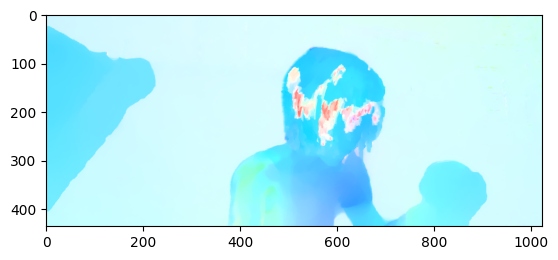

In [ ]:
tv1_image = flow_to_image(flowDTVL2)
plt.imshow(tv1_image)
plt.show()

In [ ]:
def load_flow(path):
    divisor = 64
    with open(path, 'rb') as f:
        magic = float(np.fromfile(f, np.float32, count = 1)[0])
        if magic == 202021.25:
            w, h = np.fromfile(f, np.int32, count = 1)[0], np.fromfile(f, np.int32, count = 1)[0]
            flow = np.fromfile(f, np.float32, count = h*w*2)
            flow.resize((h, w, 2))
            H = flow.shape[0]
            W = flow.shape[1]
            H_ = int(math.ceil(H/divisor) * divisor)
            W_ = int(math.ceil(W/divisor) * divisor)
            # flow = cv2.resize(flow, (W_, H_))
            flow = flow[:, :, ::-1]
            flow = 1.0 * flow/255
            flow = np.transpose(flow, (2, 0, 1))
            flow = torch.from_numpy(flow)
            # flow = flow.expand(1, flow.size()[0], flow.size()[1], flow.size()[2])
            flow = flow.float()
            return flow
        return None

In [ ]:
import math 
import torch
import torchvision

path = '/content/drive/My Drive/IVP_Project/frame_0001.flo'
#flow_gt = load_flow(path)
flow_gt = torch.permute(torch.squeeze(load_flow(path)), (1, 2, 0))

In [ ]:
pred_flow = flowDTVL2

evaluate_flow(flow_gt.numpy(), pred_flow)

<ipython-input-29-e83b89ae1155>:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  index_su = su[ind2]
<ipython-input-29-e83b89ae1155>:80: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  index_sv = sv[ind2]
<ipython-input-29-e83b89ae1155>:85: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  index_stu = stu[ind2]
<ipython

2.6951203

In [ ]:
def load_flow_new(path):
    with open(path, 'rb') as f:
        magic = float(np.fromfile(f, np.float32, count = 1)[0])
        if magic == 202021.25:
            w, h = np.fromfile(f, np.int32, count = 1)[0], np.fromfile(f, np.int32, count = 1)[0]
            data = np.fromfile(f, np.float32, count = h*w*2)
            data.resize((h, w, 2))
            print(data.shape)
            data = 1.0 * data
            # data = np.swapaxes(np.swapaxes(data, 0, 1), 1, 2)
            data = torch.from_numpy(data)
            data = data.float()
            return data
        return None

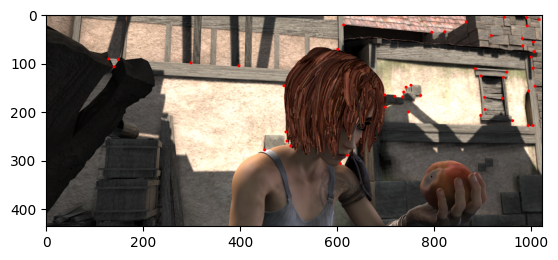

In [ ]:
path = '/content/drive/My Drive/IVP_Project/frame_0001.png'
img = cv2.imread(path)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


corners = cv2.goodFeaturesToTrack(gray,50,0.01,10)


corners = np.int0(corners)


for i in corners:
   x,y = i.ravel()
   cv2.circle(img,(x,y),3,(0,0,255),-1)

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()